NOTEBOOK - LIMPIO

1 - IMPORTAMOS LIBRERIAS Y LEEMOS LOS DATOS

In [75]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly as pl
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

pl.offline.init_notebook_mode(connected=True)
data= "../../Data/properatti.csv"
propiedades= pd.read_csv(data)

COMENZAMOS CON LA LIMPIEZA DE DATOS


In [76]:
#creamos un dataframe nuevo tomando en cuenta solo las propiedades de Capital Federal
propiedades_capital=propiedades.loc[(propiedades.state_name=="Capital Federal")]
propiedades_capital.state_name.value_counts()

Capital Federal    32316
Name: state_name, dtype: int64

In [77]:
#creamos una serie dummy para saber el tipo de cambio utilizado a la fecha del registro
#SOLO DE MANERA INFORMATIVA
dummy=propiedades_capital['price_aprox_local_currency']/propiedades_capital['price_aprox_usd']
tasa_cambio=dummy.mean()
tasa_cambio

17.644499993856833

In [78]:
#chequeamos la cantidad de valores faltantes en la columna price_usd_per_m2
#nos interesa ese campo ya que el precio en moneda local está sujeto a una tasa de cambio muy volatil 
#o inestables en el tiempo (tenemos la tasa de cambio a la fecha que se creo el DF pero no cuando se grabaron los datos 
#de cada propiedad), en este caso nos guiaremos por el valor en USD$ y el area o superficie de la propiedad
propiedades_capital.isna().sum()

Unnamed: 0                        0
operation                         0
property_type                     0
place_name                        0
place_with_parent_names           0
country_name                      0
state_name                        0
geonames_id                    1286
lat-lon                        8546
lat                            8546
lon                            8546
price                          3298
currency                       3298
price_aprox_local_currency     3298
price_aprox_usd                3298
surface_total_in_m2            5879
surface_covered_in_m2          2339
price_usd_per_m2               8882
price_per_m2                   4992
floor                         29307
rooms                         16991
expenses                      25724
properati_url                     0
description                       0
title                             0
image_thumbnail                 488
dtype: int64

In [79]:
#Columnas con pocos valores
i=0
for label, content in propiedades_capital.iteritems():
    num=len(pd.unique(propiedades_capital.iloc[:,i]))
    porcentaje=float(num)/propiedades_capital.shape[0]*100
    print("%s, %d, %.1f%%"%(label,num,porcentaje))
    propiedades_capital.iteritems()
    i=i+1


Unnamed: 0, 32316, 100.0%
operation, 1, 0.0%
property_type, 4, 0.0%
place_name, 62, 0.2%
place_with_parent_names, 62, 0.2%
country_name, 1, 0.0%
state_name, 1, 0.0%
geonames_id, 53, 0.2%
lat-lon, 14161, 43.8%
lat, 13885, 43.0%
lon, 13900, 43.0%
price, 5205, 16.1%
currency, 4, 0.0%
price_aprox_local_currency, 5295, 16.4%
price_aprox_usd, 5295, 16.4%
surface_total_in_m2, 751, 2.3%
surface_covered_in_m2, 618, 1.9%
price_usd_per_m2, 10877, 33.7%
price_per_m2, 11747, 36.4%
floor, 86, 0.3%
rooms, 19, 0.1%
expenses, 755, 2.3%
properati_url, 32316, 100.0%
description, 26094, 80.7%
title, 18144, 56.1%
image_thumbnail, 30255, 93.6%


In [80]:
#Observamos si hay filas duplicadas y de ser asi las eliminamos
duplicado = propiedades_capital.duplicated()
print(duplicado.any())
print(propiedades_capital[duplicado])
print(propiedades.shape)
propiedades.drop_duplicates(inplace=True)
print(propiedades.shape)

False
Empty DataFrame
Columns: [Unnamed: 0, operation, property_type, place_name, place_with_parent_names, country_name, state_name, geonames_id, lat-lon, lat, lon, price, currency, price_aprox_local_currency, price_aprox_usd, surface_total_in_m2, surface_covered_in_m2, price_usd_per_m2, price_per_m2, floor, rooms, expenses, properati_url, description, title, image_thumbnail]
Index: []

[0 rows x 26 columns]
(121220, 26)
(121220, 26)


In [81]:
#creamos una serie nueva tomando el promedio del m2 en dolares con respecto al barrio (lo usaremos posteriormente para llenas los NaN)

pricem2USD_fill_values=propiedades_capital.groupby('place_name').price_usd_per_m2.mean()
pricem2USD_fill_values

place_name
Abasto              2057.529147
Agronomía           2088.124134
Almagro             2749.102521
Balvanera           1982.249390
Barracas            1969.946866
                       ...     
Villa Riachuelo     1110.690766
Villa Santa Rita    1889.186620
Villa Soldati        743.666758
Villa Urquiza       2495.288265
Villa del Parque    2233.837905
Name: price_usd_per_m2, Length: 62, dtype: float64

In [82]:
#creamos un dataFrame nuevo con los valores de la serie obtenida anteriormente y hacemos un merge a propiedades_capital2 en una nueva columna 
#con el promedio del m2 en dolares

pricem2USD_fill_values_df= pd.DataFrame(pricem2USD_fill_values)
pricem2USD_fill_values_df.reset_index(inplace=True)
propiedades_capital2=propiedades_capital.merge(pricem2USD_fill_values_df, on= 'place_name', how='left', suffixes = ("", "_mean"))

#usamos fillna para substituir los NaN con los valores en la columna price_usd_per_m2_mean
propiedades_capital2.price_usd_per_m2.fillna(propiedades_capital2.price_usd_per_m2_mean, inplace = True)

In [83]:
#chequeamos que no existan NaN en price_usd_per_m2
propiedades_capital2.price_usd_per_m2.isna().sum()

0

In [84]:
#hacemos un describe la columna price_usd_per_m2
propiedades_capital2.price_usd_per_m2.describe()

count     32316.000000
mean       3040.608512
std        3230.037746
min          13.797467
25%        2000.000000
50%        2495.288265
75%        3153.981976
max      206333.333333
Name: price_usd_per_m2, dtype: float64

In [85]:
#removemos los outliers de ese campo
removed_outliers = propiedades_capital2.price_usd_per_m2.between(propiedades_capital2.price_usd_per_m2.quantile(.05), propiedades_capital2.price_usd_per_m2.quantile(.95))

<AxesSubplot:xlabel='Barrios'>

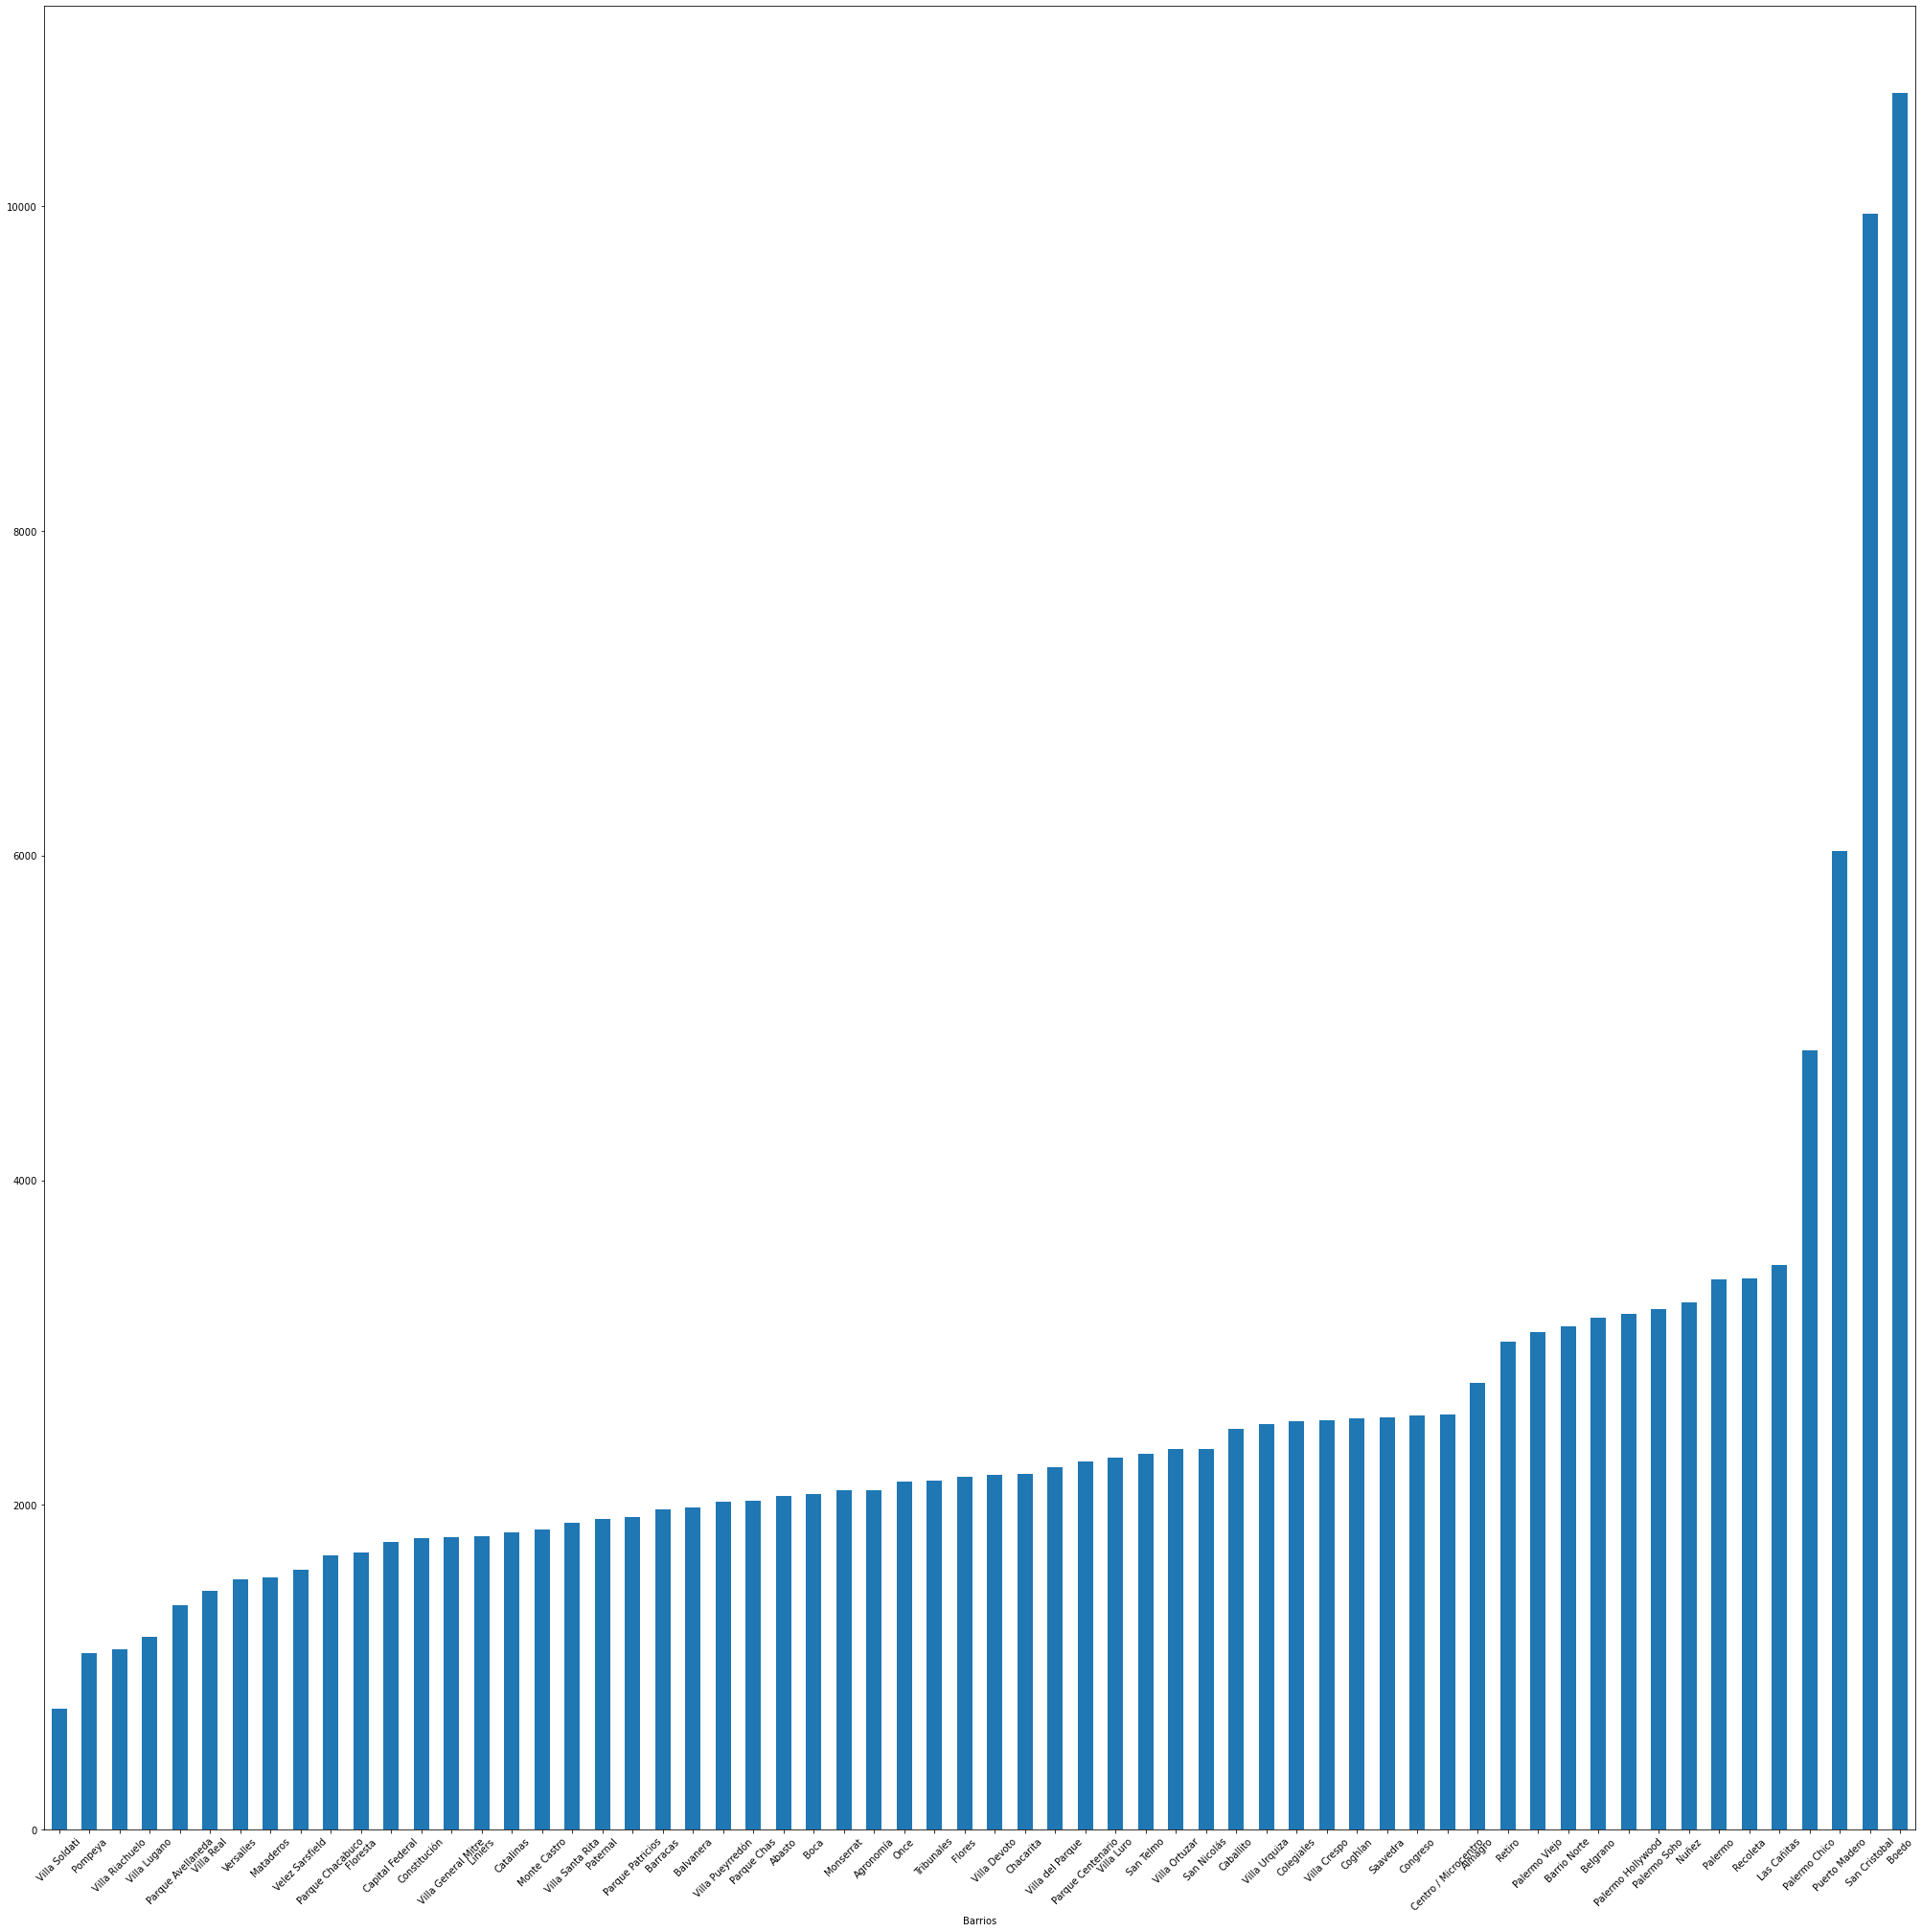

In [86]:
#graficamos el dataframe sin limpiar
serie_x=pd.unique(propiedades_capital2.place_name)
serie_x
serie_y=propiedades_capital2.groupby('place_name').price_usd_per_m2.mean()
serie_y.sort_values().plot.bar(rot=45,figsize=(35,35), xlabel='Barrios')

<AxesSubplot:xlabel='Barrios'>

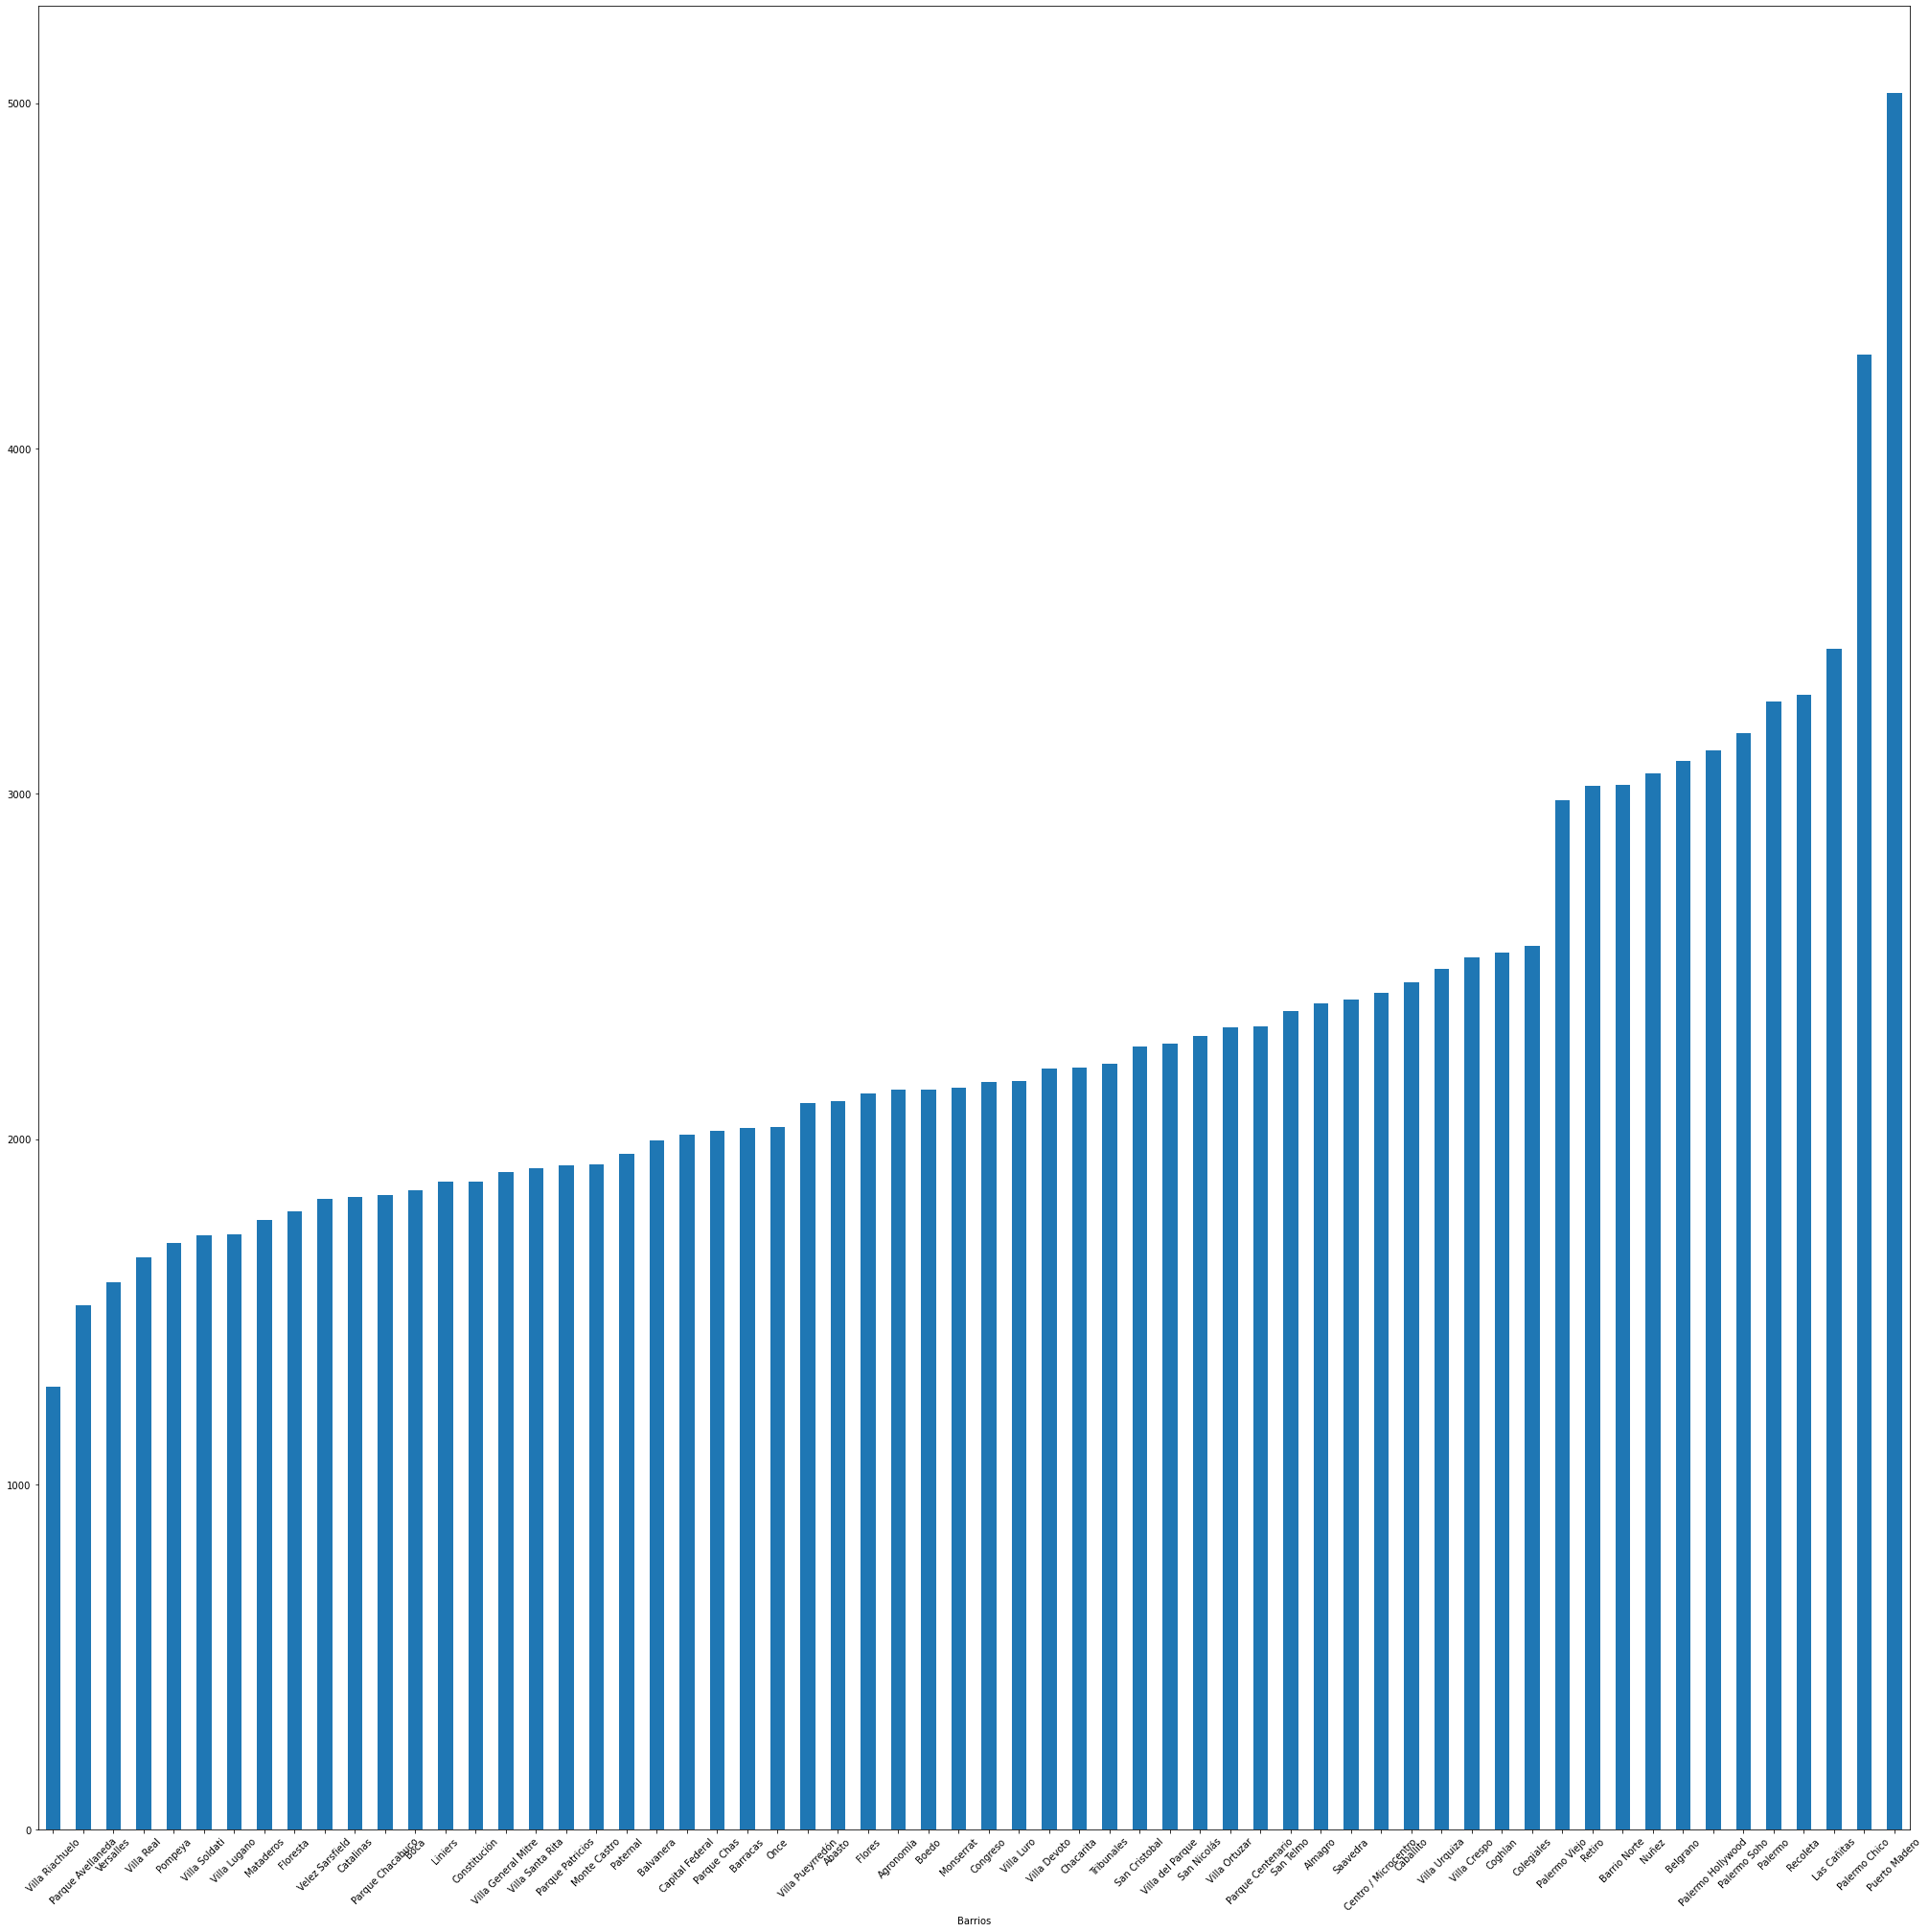

In [87]:
##graficamos el dataframe limpio
serie_x=pd.unique(propiedades_capital2.place_name)
serie_x
serie_y=propiedades_capital2[removed_outliers].groupby('place_name').price_usd_per_m2.mean()
serie_y.sort_values().plot.bar(rot=45,figsize=(35,35), xlabel='Barrios')

In [88]:
#revisamos cuales otras columnas faltan por datos
propiedades_capital2.isna().sum()


Unnamed: 0                        0
operation                         0
property_type                     0
place_name                        0
place_with_parent_names           0
country_name                      0
state_name                        0
geonames_id                    1286
lat-lon                        8546
lat                            8546
lon                            8546
price                          3298
currency                       3298
price_aprox_local_currency     3298
price_aprox_usd                3298
surface_total_in_m2            5879
surface_covered_in_m2          2339
price_usd_per_m2                  0
price_per_m2                   4992
floor                         29307
rooms                         16991
expenses                      25724
properati_url                     0
description                       0
title                             0
image_thumbnail                 488
price_usd_per_m2_mean             0
dtype: int64

In [89]:
#observamos que el campo un campo valioso para determinar el precio es el area de la propiedad
#en este caso no podriamos hacer un promedio, procedemos a removerla surface_covered_in_m2
propiedades_capital3=propiedades_capital2.dropna(axis=0,how='any',subset=['surface_covered_in_m2'])
propiedades_capital3.isna().sum()

Unnamed: 0                        0
operation                         0
property_type                     0
place_name                        0
place_with_parent_names           0
country_name                      0
state_name                        0
geonames_id                    1218
lat-lon                        7896
lat                            7896
lon                            7896
price                          2651
currency                       2651
price_aprox_local_currency     2651
price_aprox_usd                2651
surface_total_in_m2            5093
surface_covered_in_m2             0
price_usd_per_m2                  0
price_per_m2                   2653
floor                         27075
rooms                         15120
expenses                      23825
properati_url                     0
description                       0
title                             0
image_thumbnail                 432
price_usd_per_m2_mean             0
dtype: int64

In [90]:
#funcion para extraer del campo description, el numero de ambientes o habitaciones
def limpieza_description(text):
    try:
        txt="(\d+(?=\s+dorm)|\d(?=\s+amb)|\d(?=\s+hab))"
        txt=txt.lower()
        x=int(re.findall(txt, text)[0])
        
    except IndexError:
        x="1"
    return(x) 

In [91]:
#creamos un df nuevo solo con casas y departamentos para poder limpiar la descripcion
propiedades_capital_casas_dptops=propiedades_capital3.loc[(propiedades_capital3.property_type=="apartment")|(propiedades_capital3.property_type=="house")|(propiedades_capital3.property_type=="PH")]

In [92]:
propiedades_capital3.dtypes

Unnamed: 0                      int64
operation                      object
property_type                  object
place_name                     object
place_with_parent_names        object
country_name                   object
state_name                     object
geonames_id                   float64
lat-lon                        object
lat                           float64
lon                           float64
price                         float64
currency                       object
price_aprox_local_currency    float64
price_aprox_usd               float64
surface_total_in_m2           float64
surface_covered_in_m2         float64
price_usd_per_m2              float64
price_per_m2                  float64
floor                         float64
rooms                         float64
expenses                      float64
properati_url                  object
description                    object
title                          object
image_thumbnail                object
price_usd_pe

In [93]:
#creamos el patron REGEX para la busqueda de palabras como "dorm","amb" y "hab". Este patron buscará el primer numero 
#que consiga antes de alguna de esas palabras

pricem2USD_fill_values
propiedades_capital3['rooms_fill']=propiedades_capital3['description'].apply(lambda x: limpieza_description(x))

C:\Users\edgar\AppData\Local\Temp/ipykernel_4844/1369611069.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [94]:
#propiedades_capital3.columns
propiedades_capital3[['description','rooms','rooms_fill']].sample(5)

,description,rooms,rooms_fill
18037,Monoambiente con balcón. Apto profesional.Coc...,NaN,1
24111,Entrega Marzo 2019Forma de pago 50% y 22 cuota...,NaN,1
32297,Monoambiente NUEVO en el complejo Cabildo Estu...,NaN,1
27521,Solo para exigentes: Excelente Edificio sito e...,NaN,1
20812,PRE-VENTA DEPARTAMENTO DE 2 AMBIENTES EN BELGR...,NaN,1


In [95]:
#Inputamos los valores Nan de la columna rooms, usando los valores de rooms_fill que obtuvimos de la ultima ejecucion
propiedades_capital3.rooms.fillna(propiedades_capital3.rooms_fill, inplace = True)
propiedades_capital3.dtypes

C:\Users\edgar\Anaconda3\envs\dhdsblend2021\lib\site-packages\pandas\core\series.py:4530: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Unnamed: 0                      int64
operation                      object
property_type                  object
place_name                     object
place_with_parent_names        object
country_name                   object
state_name                     object
geonames_id                   float64
lat-lon                        object
lat                           float64
lon                           float64
price                         float64
currency                       object
price_aprox_local_currency    float64
price_aprox_usd               float64
surface_total_in_m2           float64
surface_covered_in_m2         float64
price_usd_per_m2              float64
price_per_m2                  float64
floor                         float64
rooms                          object
expenses                      float64
properati_url                  object
description                    object
title                          object
image_thumbnail                object
price_usd_pe

In [96]:
#Seleccionamos las columnas que nos resultan utiles para un modelo posterior
propiedades_capital_limpio=propiedades_capital3[['property_type','place_name','price','price_aprox_local_currency','price_aprox_usd','surface_total_in_m2',
       'surface_covered_in_m2','price_usd_per_m2','price_per_m2','floor','rooms','description','price_usd_per_m2_mean']]
propiedades_capital_limpio.rooms=propiedades_capital_limpio.rooms.astype(np.float)

C:\Users\edgar\Anaconda3\envs\dhdsblend2021\lib\site-packages\pandas\core\generic.py:5170: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



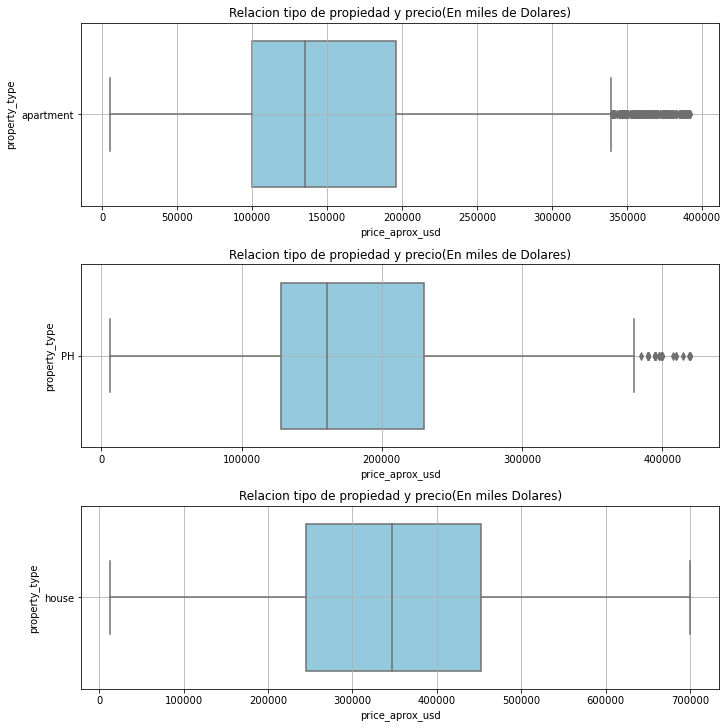

In [97]:
#Utilizamos estos boxplot para analizar la relacion entre los tipos de propiedad y los precios en dolares
propiedades_capital_limpio=propiedades_capital_limpio.dropna(axis=0,how='any',subset=['price_aprox_usd'])
dptos=propiedades_capital_limpio[propiedades_capital_limpio["property_type"]=="apartment"]
phs=propiedades_capital_limpio[propiedades_capital_limpio["property_type"]=="PH"]
casas=propiedades_capital_limpio[propiedades_capital_limpio["property_type"]=="house"]
dptos= dptos[(dptos.price <= 392500.0) & (dptos.price >=65000.0) ]
phs=phs[(phs.price <= 428500.0) & (phs.price >=75000.0) ]
casas=casas[(casas.price <= 706000.0) & (casas.price >=110000.0) ]
figure,(ax1,ax2,ax3) = plt.subplots(3,constrained_layout=True,figsize=(10,10))
ax1.set_title("Relacion tipo de propiedad y precio(En miles de Dolares)")
ax2.set_title("Relacion tipo de propiedad y precio(En miles de Dolares)")
ax3.set_title("Relacion tipo de propiedad y precio(En miles Dolares)")
sns.boxplot(data=dptos,x="price_aprox_usd",y="property_type",ax=ax1, color='skyblue')
sns.boxplot(data=phs,x="price_aprox_usd",y="property_type",ax=ax2, color='skyblue')
sns.boxplot(data=casas,x="price_aprox_usd",y="property_type",ax=ax3, color='skyblue')
ax1.grid()
ax2.grid()
ax3.grid()
plt.show()

In [98]:
#porcentaje de valores nulos por columna
col_null_caba=np.sum(propiedades_capital_limpio.isnull())
col_null_caba.sort_values(ascending=False)
porc_nulos_caba=np.round((col_null_caba/propiedades_capital_limpio.shape[0])*100,2)
porc_nulos_caba.sort_values(ascending=False)


floor                         89.54
surface_total_in_m2           18.32
price_per_m2                   0.01
price_usd_per_m2_mean          0.00
description                    0.00
rooms                          0.00
price_usd_per_m2               0.00
surface_covered_in_m2          0.00
price_aprox_usd                0.00
price_aprox_local_currency     0.00
price                          0.00
place_name                     0.00
property_type                  0.00
dtype: float64

In [99]:
propiedades_capital_surface_covered_fill=propiedades_capital_limpio.groupby('place_name').surface_covered_in_m2.mean()
propiedades_capital_limpio_surface_total_fill=propiedades_capital_limpio.groupby('place_name').surface_total_in_m2.mean()
propiedades_capital_surface=propiedades_capital_limpio_surface_total_fill/propiedades_capital_surface_covered_fill

In [100]:
propiedades_capital_surface_fill_pd=pd.DataFrame(propiedades_capital_surface)
propiedades_capital_surface_fill_pd.reset_index(inplace=True)
propiedades_capital_surface_fill_pd.columns=['place_name','surface_mean']
propiedades_capital_surface_limpio=propiedades_capital_limpio.merge(propiedades_capital_surface_fill_pd, on='place_name', how='left',suffixes = ("", "_mean"))


In [101]:
propiedades_capital_surface_limpio.rename(columns={'0': 'surface_mean'})
propiedades_capital_surface_limpio.columns

Index(['property_type', 'place_name', 'price', 'price_aprox_local_currency',
       'price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2',
       'price_usd_per_m2', 'price_per_m2', 'floor', 'rooms', 'description',
       'price_usd_per_m2_mean', 'surface_mean'],
      dtype='object')

In [102]:
surface_total_in_m2 = propiedades_capital_limpio['surface_total_in_m2'].mean()
surface_total_in_m2
surface_covered_in_m2 = propiedades_capital_limpio['surface_covered_in_m2'].mean()
surface_covered_in_m2 
surface_covered_in_m2 * 100 / surface_total_in_m2

88.26944144005208

In [103]:
propiedades_capital_surface_limpio_dptos=propiedades_capital_surface_limpio[propiedades_capital_surface_limpio["property_type"]=="apartment"]
propiedades_capital_surface_limpio_casas=propiedades_capital_surface_limpio[propiedades_capital_surface_limpio["property_type"]=="house"]
propiedades_capital_surface_limpio_phs=propiedades_capital_surface_limpio[propiedades_capital_surface_limpio["property_type"]=="PH"]
propiedades_capital_surface_limpio_stores=propiedades_capital_surface_limpio[propiedades_capital_surface_limpio["property_type"]=="store"]

In [104]:
#propiedades_capital_surface_limpio_casas.surface_total_in_m2[removed_outliers_casas].describe()
propiedades_capital_surface_limpio_dptos.surface_total_in_m2.describe()

count    19012.000000
mean        78.596886
std         64.897096
min         10.000000
25%         40.000000
50%         56.000000
75%         90.000000
max        860.000000
Name: surface_total_in_m2, dtype: float64

In [105]:
propiedades_capital_surface_limpio_dptos.surface_total_in_m2.nlargest(10)

22518    860.0
874      789.0
2497     720.0
5014     720.0
2711     688.0
13907    684.0
5016     666.0
10808    655.0
15752    639.0
15753    639.0
Name: surface_total_in_m2, dtype: float64

In [106]:
propiedades_capital_surface_limpio.isna().sum()

property_type                     0
place_name                        0
price                             0
price_aprox_local_currency        0
price_aprox_usd                   0
surface_total_in_m2            5007
surface_covered_in_m2             0
price_usd_per_m2                  0
price_per_m2                      2
floor                         24467
rooms                             0
description                       0
price_usd_per_m2_mean             0
surface_mean                      0
dtype: int64

In [107]:
propiedades_capital_surface_limpio_casas=propiedades_capital_surface_limpio_casas[(propiedades_capital_surface_limpio_casas.surface_total_in_m2 <= 3500) & (propiedades_capital_surface_limpio_casas.surface_total_in_m2 >=30) ]
propiedades_capital_surface_limpio_phs=propiedades_capital_surface_limpio_phs[(propiedades_capital_surface_limpio_phs.surface_total_in_m2 <= 1000) & (propiedades_capital_surface_limpio_phs.surface_total_in_m2 >=10) ]
propiedades_capital_surface_limpio_dptos=propiedades_capital_surface_limpio_dptos[(propiedades_capital_surface_limpio_dptos.surface_total_in_m2 <= 8000) & (propiedades_capital_surface_limpio_dptos.surface_total_in_m2 >=10) ]

In [108]:
diferencia_surface_ph=propiedades_capital_surface_limpio_phs.surface_total_in_m2.mean() / propiedades_capital_surface_limpio_phs.surface_covered_in_m2.mean()
diferencia_surface_casas=propiedades_capital_surface_limpio_casas.surface_total_in_m2.mean() / propiedades_capital_surface_limpio_casas.surface_covered_in_m2.mean()
diferencia_surface_dptos=propiedades_capital_surface_limpio_dptos.surface_total_in_m2.mean() / propiedades_capital_surface_limpio_dptos.surface_covered_in_m2.mean()
diferencia_surface_stores=propiedades_capital_surface_limpio_stores.surface_total_in_m2.mean() / propiedades_capital_surface_limpio_stores.surface_covered_in_m2.mean()

print("Porcentaje de diferencia para PH: "+str(np.around(diferencia_surface_ph,decimals=2)) + "%")
print("Porcentaje de diferencia para Dptos: "+str(np.around(diferencia_surface_dptos, decimals=2)) + "%")
print("Porcentaje de diferencia para Casas: "+str(np.around(diferencia_surface_casas, decimals=2)) + "%")
print("Porcentaje de diferencia para Tiendas: "+str(np.around(diferencia_surface_stores, decimals=2)) + "%")

Porcentaje de diferencia para PH: 1.34%
Porcentaje de diferencia para Dptos: 1.14%
Porcentaje de diferencia para Casas: 1.83%
Porcentaje de diferencia para Tiendas: 1.13%


In [109]:
print("Un describe al dataset ANTES de aplicar la multiplicacion por el procentaje de diferencia: ")
print(propiedades_capital_surface_limpio.surface_total_in_m2.describe())
print("")
print("Hay "+str(propiedades_capital_surface_limpio.surface_total_in_m2.isna().sum())+ " valores NaN para surface_covered_in_m2")

Un describe al dataset ANTES de aplicar la multiplicacion por el procentaje de diferencia: 
count    22319.000000
mean       111.486626
std        212.760083
min         10.000000
25%         42.000000
50%         62.000000
75%        111.000000
max      10958.000000
Name: surface_total_in_m2, dtype: float64

Hay 5007 valores NaN para surface_covered_in_m2


In [110]:
propiedades_capital_surface_limpio[['property_type','place_name','surface_total_in_m2','surface_covered_in_m2']].nlargest(10, columns='surface_total_in_m2')

,property_type,place_name,surface_total_in_m2,surface_covered_in_m2
16126,store,Villa Soldati,10958.0,10958.0
2146,house,Capital Federal,7832.0,4111.0
15954,store,Boca,7722.0,7722.0
19994,store,San Telmo,5079.0,5079.0
15863,store,Villa Luro,4800.0,4800.0
16123,store,Capital Federal,4800.0,4800.0
15906,store,Parque Patricios,4590.0,4590.0
22689,store,San Telmo,4300.0,3800.0
16010,store,Parque Patricios,4229.0,4229.0
16017,store,San Telmo,3800.0,3800.0


In [111]:
propiedades_capital_surface_limpio.property_type.value_counts()

apartment    22880
house         1722
PH            1676
store         1048
Name: property_type, dtype: int64

In [112]:
propiedades_capital_surface_limpio_post=propiedades_capital_surface_limpio.loc[(propiedades_capital_surface_limpio.property_type=="apartment")|(propiedades_capital_surface_limpio.property_type=="house")|(propiedades_capital_surface_limpio.property_type=="PH")|(propiedades_capital_surface_limpio.property_type=="store")]

#propiedades_capital_surface_limpio_post=propiedades_capital_surface_limpio_post.apply(lambda x: x['surface_covered_in_m2']*diferencia_surface_ph if x['property_type']=='PH' and pd.isna(x['surface_total_in_m2']) else x,axis=1)
#propiedades_capital_surface_limpio_post.loc[propiedades_capital_surface_limpio_post['property_type'] == 'PH' & propiedades_capital_surface_limpio_post['surface_total_in_m2'].isnull(), 'surface_total_in_m2'] = diferencia_surface_ph * surface_total_in_m2
#propiedades_capital_surface_limpio_post.loc[propiedades_capital_surface_limpio_post['property_type'] == 'PH' && propiedades_capital_surface_limpio_post['surface_total_in_m2'].isnull(), 'surface_total_in_m2'] = propiedades_capital_surface_limpio_post['diferencia_surface_ph'] * propiedades_capital_surface_limpio_post['surface_total_in_m2']
def diferencia(x):
    #total=x['surface_total_in_m2']
    total=np.around(x['surface_total_in_m2'], decimals=1)
    if x['property_type'] == 'PH' and pd.isna(x['surface_total_in_m2']):
        total = int(x['surface_covered_in_m2']) * diferencia_surface_ph
        return(total)
    elif x['property_type'] == 'apartment' and pd.isna(x['surface_total_in_m2']):
        total = int(x['surface_covered_in_m2']) * diferencia_surface_dptos
        return(total)
    elif x['property_type'] == 'store' and pd.isna(x['surface_total_in_m2']):
        total = x['surface_covered_in_m2'] * diferencia_surface_stores
        return(total)
    elif x['property_type'] == 'house' and pd.isna(x['surface_total_in_m2']):
        total = x['surface_covered_in_m2'] * diferencia_surface_casas
        return(total)
    else:
        return(total)
propiedades_capital_surface_limpio_post["_new_surface_total"]=propiedades_capital_surface_limpio_post.apply(lambda x: diferencia(x), axis=1) 

In [135]:
propiedades_capital_surface_limpio_post[["_new_surface_total",'property_type','place_name','surface_total_in_m2','surface_covered_in_m2']].sample(10)

,_new_surface_total,property_type,place_name,surface_total_in_m2,surface_covered_in_m2
21605,99.000000,apartment,Barracas,99.000000,90.0
25147,63.000000,apartment,Villa Urquiza,63.000000,60.0
16332,51.000000,apartment,Palermo,51.000000,49.0
7284,44.000000,apartment,Liniers,44.000000,42.0
775,61.303726,apartment,San Telmo,61.303726,54.0
5952,30.000000,apartment,Boedo,30.000000,30.0
2078,40.000000,apartment,Villa Ortuzar,40.000000,40.0
19974,45.000000,apartment,San Telmo,45.000000,42.0
6166,38.000000,apartment,Congreso,38.000000,38.0
26920,65.000000,PH,Paternal,65.000000,65.0


In [114]:
#Inputamos los valores NaN en superficie total con los valores nuevos del apply y la funcion
propiedades_capital_surface_limpio_post.surface_total_in_m2.fillna(propiedades_capital_surface_limpio_post._new_surface_total, inplace = True)

In [133]:
propiedades_capital_surface_limpio_post[['property_type','place_name','surface_total_in_m2','surface_covered_in_m2']].nlargest(10,'surface_total_in_m2')

,property_type,place_name,surface_total_in_m2,surface_covered_in_m2
18070,apartment,Barrio Norte,212292.532982,187000.0
13548,house,Liniers,14957.237973,8175.0
16126,store,Villa Soldati,10958.000000,10958.0
13471,apartment,Monte Castro,10389.846320,9152.0
15643,apartment,Palermo,7979.701681,7029.0
2146,house,Capital Federal,7832.000000,4111.0
15954,store,Boca,7722.000000,7722.0
24468,apartment,Floresta,7417.750858,6534.0
25806,apartment,Flores,6881.910882,6062.0
977,apartment,Caballito,6073.609901,5350.0


In [116]:
propiedades_capital_surface_limpio_post[['property_type','place_name','surface_total_in_m2','surface_covered_in_m2']].sample(10)

,property_type,place_name,surface_total_in_m2,surface_covered_in_m2
6815,apartment,Caballito,71.521014,63.0
17447,apartment,Belgrano,55.000000,48.0
210,PH,Parque Patricios,26.786616,20.0
26279,apartment,Centro / Microcentro,75.000000,72.0
16423,apartment,Paternal,39.733897,35.0
12541,apartment,Caballito,45.410167,40.0
26967,apartment,Coghlan,83.000000,75.0
14726,store,Palermo,40.000000,40.0
21794,apartment,San Cristobal,45.000000,41.0
10927,apartment,Chacarita,40.000000,40.0


In [117]:
print("Un describe al dataset DESPUES de aplicar la multiplicacion por el procentaje de diferencia: ")
propiedades_capital_surface_limpio_post.surface_total_in_m2.describe()

Un describe al dataset DESPUES de aplicar la multiplicacion por el procentaje de diferencia: 


count     27326.000000
mean        122.654754
std        1308.713163
min           1.135254
25%          42.000000
50%          63.574234
75%         112.503788
max      212292.532982
Name: surface_total_in_m2, dtype: float64

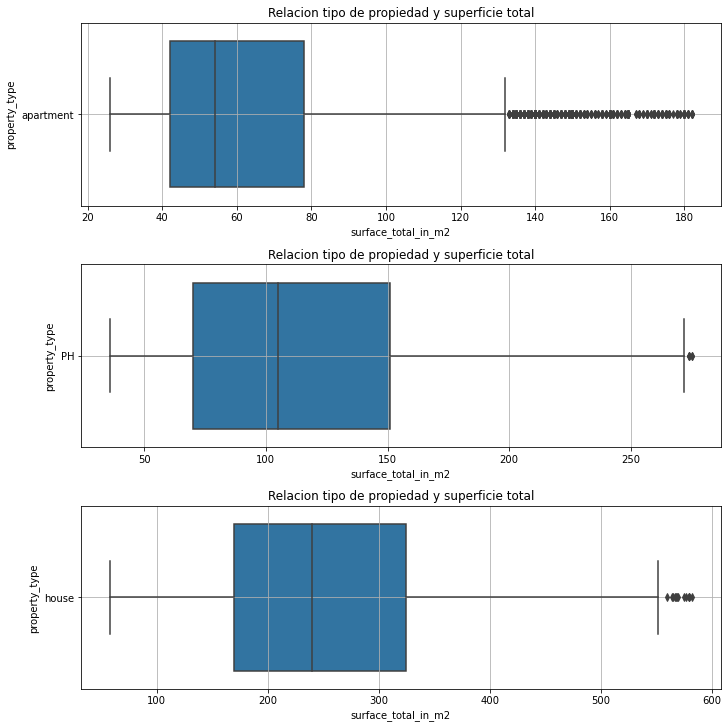

In [118]:
dptos= dptos[(dptos.surface_total_in_m2 <= 182.91) & (dptos.surface_total_in_m2 >=26.0) ]
phs=phs[(phs.surface_total_in_m2 <= 275.0) & (phs.surface_total_in_m2 >=35.0) ]
casas=casas[(casas.surface_total_in_m2 <= 583.12) & (casas.surface_total_in_m2 >=56.81) ]
figure,(ax1,ax2,ax3) = plt.subplots(3,constrained_layout=True,figsize=(10,10))
ax1.set_title("Relacion tipo de propiedad y superficie total")
ax2.set_title("Relacion tipo de propiedad y superficie total")
ax3.set_title("Relacion tipo de propiedad y superficie total")
sns.boxplot(data=dptos,x="surface_total_in_m2",y="property_type",ax=ax1)
sns.boxplot(data=phs,x="surface_total_in_m2",y="property_type",ax=ax2)
sns.boxplot(data=casas,x="surface_total_in_m2",y="property_type",ax=ax3)
ax1.grid()
ax2.grid()
ax3.grid()
plt.show()

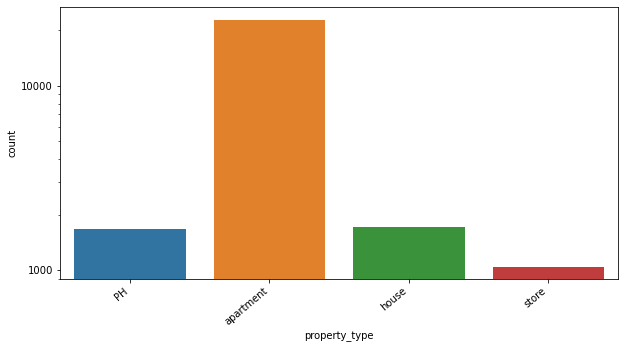

In [119]:
plt.figure(figsize=(10,5))
from matplotlib.ticker import ScalarFormatter

plt.yscale('log')
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
ax = sns.countplot(data = propiedades_capital_surface_limpio, x = "property_type")
ax.set_xticklabels(ax.get_xticklabels(),rotation=40,ha="right")


plt.show()

<AxesSubplot:>

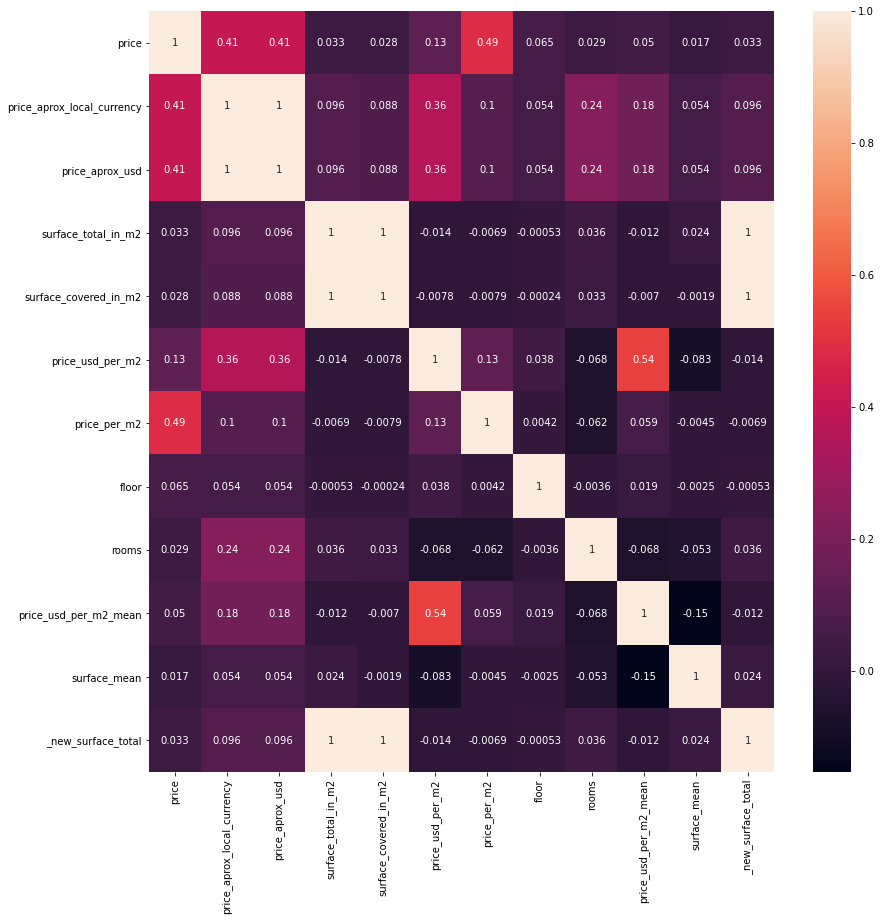

In [120]:
#Realizamos un heatmap para observar el grado de correlacion entre las variables
#propiedades_capital_surface_limpio=propiedades_capital_surface_limpio.drop('surface_mean',axis=1)
#propiedades_capital_surface_limpio=propiedades_capital_surface_limpio.drop('price_usd_per_m2_mean', axis=1)
fig =plt.subplots(figsize=(14,14))
sns.heatmap(propiedades_capital_surface_limpio_post.corr(), annot=True)

In [121]:
propiedades_capital_surface_limpio_post.dtypes


property_type                  object
place_name                     object
price                         float64
price_aprox_local_currency    float64
price_aprox_usd               float64
surface_total_in_m2           float64
surface_covered_in_m2         float64
price_usd_per_m2              float64
price_per_m2                  float64
floor                         float64
rooms                         float64
description                    object
price_usd_per_m2_mean         float64
surface_mean                  float64
_new_surface_total            float64
dtype: object

In [122]:
propiedades_capital_surface_limpio.isna().sum()

property_type                     0
place_name                        0
price                             0
price_aprox_local_currency        0
price_aprox_usd                   0
surface_total_in_m2            5007
surface_covered_in_m2             0
price_usd_per_m2                  0
price_per_m2                      2
floor                         24467
rooms                             0
description                       0
price_usd_per_m2_mean             0
surface_mean                      0
dtype: int64

In [123]:
propiedades_capital_surface_limpio_post.dtypes

property_type                  object
place_name                     object
price                         float64
price_aprox_local_currency    float64
price_aprox_usd               float64
surface_total_in_m2           float64
surface_covered_in_m2         float64
price_usd_per_m2              float64
price_per_m2                  float64
floor                         float64
rooms                         float64
description                    object
price_usd_per_m2_mean         float64
surface_mean                  float64
_new_surface_total            float64
dtype: object

In [124]:
dptos=propiedades_capital_surface_limpio_post[propiedades_capital_surface_limpio_post["property_type"]=="apartment"]
phs=propiedades_capital_surface_limpio_post[propiedades_capital_surface_limpio_post["property_type"]=="PH"]
casas=propiedades_capital_surface_limpio_post[propiedades_capital_surface_limpio_post["property_type"]=="house"]

In [125]:
from sklearn import *
X = casas[['price','price_usd_per_m2', 'rooms', 'surface_total_in_m2','surface_covered_in_m2']]

scaler = StandardScaler()

X_std = scaler.fit_transform(X)

y = casas['price_aprox_usd']

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.3, random_state = 117)

model_ridge_cv = linear_model.RidgeCV(alphas= [0.3, 0.5, 1.0, 1.1, 1.15, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.3, 1.4, 1.5, 10.0], 
                                   fit_intercept=True, normalize=False, cv=10)

model_fit_ridge_cv = model_ridge_cv.fit(X_train, y_train)

print(model_fit_ridge_cv.alpha_)

print(model_fit_ridge_cv.best_score_)

10.0
0.5572640507361608


In [127]:
best_alpha = model_fit_ridge_cv.alpha_
model_ridge = linear_model.Ridge(alpha = best_alpha, fit_intercept = True, normalize = False)
model_fit_ridge = model_ridge.fit(X_train, y_train)
print(model_fit_ridge.coef_)
print(model_fit_ridge.intercept_)
print(model_fit_ridge.score(X_train, y_train))

[400532.62330499  37372.7033641   -1634.34995825  45675.18642427
   9652.85014592]
505878.1228822626
0.7870693009518555


In [128]:
model_fit_ridge.score(X_test, y_test)

0.9506740069145725

In [129]:
propiedades_capital_surface_limpio.property_type.value_counts()

apartment    22880
house         1722
PH            1676
store         1048
Name: property_type, dtype: int64

In [130]:
propiedades_capital_surface_limpio.columns

Index(['property_type', 'place_name', 'price', 'price_aprox_local_currency',
       'price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2',
       'price_usd_per_m2', 'price_per_m2', 'floor', 'rooms', 'description',
       'price_usd_per_m2_mean', 'surface_mean'],
      dtype='object')

In [131]:
propiedades_capital_surface_limpio[['property_type','place_name','surface_total_in_m2']].nlargest(5, columns='surface_total_in_m2')

,property_type,place_name,surface_total_in_m2
16126,store,Villa Soldati,10958.0
2146,house,Capital Federal,7832.0
15954,store,Boca,7722.0
19994,store,San Telmo,5079.0
15863,store,Villa Luro,4800.0


In [132]:
propiedades_capital_surface_limpio_post[['property_type','place_name','surface_total_in_m2']].nlargest(5, columns='surface_total_in_m2')

,property_type,place_name,surface_total_in_m2
18070,apartment,Barrio Norte,212292.532982
13548,house,Liniers,14957.237973
16126,store,Villa Soldati,10958.000000
13471,apartment,Monte Castro,10389.846320
15643,apartment,Palermo,7979.701681
